# RTBT emittance measurement data analysis 
> 05.31.2021

NOTE: we need to find out what exactly the positions in this data set are telling us. I think the scanner is moving along the u direction, and these numbers are the distance along this direction.

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

We are taking $s_0$ to be the start of the RTBT. To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different optics settings between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, so if all these are used the coefficient array will be $15N \times 10$. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

In [1]:
import sys

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import proplot as plot
from pprint import pprint

sys.path.append('/Users/46h/Research/code/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba 

sys.path.append('/Users/46h/Research/code/accphys/pyorbit/measurement/')
from data_analysis import reconstruct

In [2]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

## View Twiss parameters at each scan index 

In [3]:
scan_indices = [0, 1, 3, 7, 11]
twiss_list = [np.loadtxt('./twiss_{}.dat'.format(i)) 
              for i in scan_indices + ['default']]

### Phase advance 

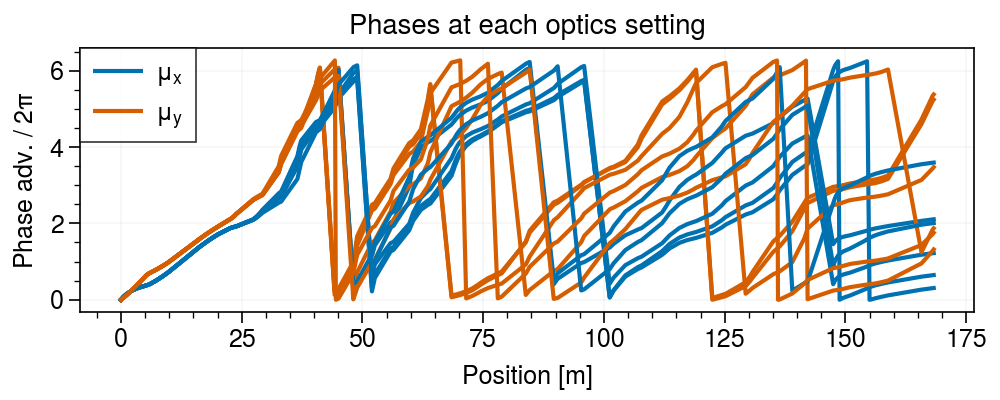

In [4]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, mu_x)
    ax.plot(pos, mu_y)
ax.legend(labels=[r'$\mu_x$', r'$\mu_y$'], ncols=1);
ax.format(ylabel=r'Phase adv. / 2$\pi$', xlabel='Position [m]',
          title='Phases at each optics setting')

### Beta functions 

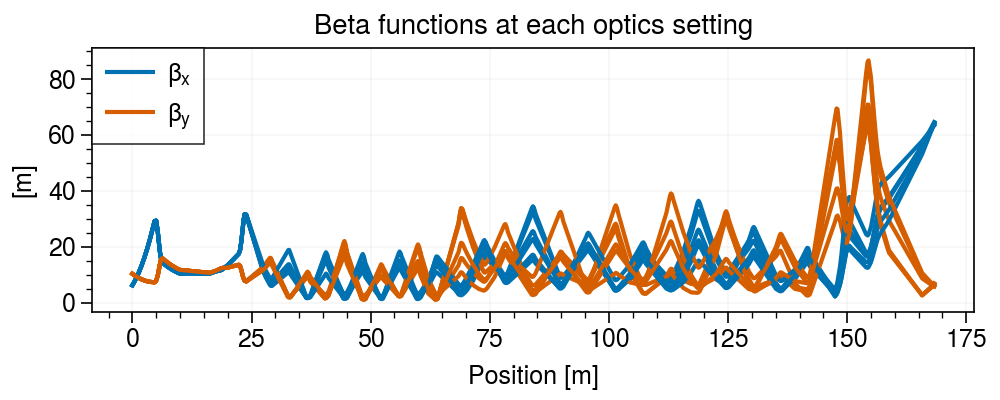

In [5]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, beta_x)
    ax.plot(pos, beta_y)
ax.legend(labels=[r'$\beta_x$', r'$\beta_y$'], ncols=1);
ax.format(ylabel='[m]', xlabel='Position [m]', 
          title='Beta functions at each optics setting')

## Process wire-scanner data 

We used a 180 degree range for the phase advances, with 12 steps total. We didn't have time to take measurements at each step. Scans are labeled from 0 through 11 to indicate the position within this array, and the 'default' tag means the machine was at its default setting. 

In [6]:
ws_ids = ['WS20', 'WS21', 'WS23', 'WS24']

In [7]:
filenames_and_indices = []
for filename in utils.list_files('./', join=False):
    if not filename.startswith('Wire') or 'default' in filename:
        continue
    index = int(filename.split('.pta')[0].split('_')[-1])
    filenames_and_indices.append([filename, index])
filenames_and_indices = sorted(filenames_and_indices, key=lambda item: item[0])
filenames, _ = zip(*filenames_and_indices)

In [8]:
# Add the default settings for now
filenames = list(filenames)
filenames.append('WireAnalysisFmt-2021.05.31_21.08.18_default.pta.txt')

### Collect raw profiles 

In [9]:
def load_profile_data(filename):
    
    # Collect lines corresponding to each wire-scanner.
    file = open(filename, 'r')
    lines, ws_id = dict(), None
    for line in file:
        line = line.rstrip()
        if line.startswith('RTBT_Diag'):
            ws_id = line.split(':')[-1]
            continue
        lines.setdefault(ws_id, []).append(line)
    file.close()
    
    # Collect intensity readings on each wire.
    data = dict()
    for ws_id in ws_ids:
        # Blank lines separate file into sections
        param_lines, raw_lines, fit_lines = utils.split_list(lines[ws_id], '')[:3]
        # Remove headers ('X Raw', 'Y Raw', etc.) and dashed line that follows.
        raw_lines = raw_lines[2:] 
        data_arr = np.array([[float(string) for string in line.split()] 
                             for line in raw_lines])
        data_arr[:, 1:4] = np.clip(data_arr[:, 1:4], 0, None)
        columns = ['pos','xraw','yraw','uraw','xpos','ypos','upos']
        data[ws_id] = pd.DataFrame(data_arr, columns=columns)
        
    return data

In [10]:
data_list = [load_profile_data(filename) for filename in filenames]
data_list[0]['WS20']

,pos,xraw,yraw,uraw,xpos,ypos,upos
0,25.0,0.0,0.004199,0.0,17.67775,17.67775,25.0
1,28.0,0.0,0.003857,0.0,19.79908,19.79908,28.0
2,31.0,0.0,0.003711,0.0,21.92041,21.92041,31.0
3,34.0,0.0,0.003857,0.0,24.04174,24.04174,34.0
4,37.0,0.0,0.003809,0.0,26.16307,26.16307,37.0
...,...,...,...,...,...,...,...
85,280.0,0.0,0.003906,0.0,197.99080,197.99080,280.0
86,283.0,0.0,0.004150,0.0,200.11213,200.11213,283.0
87,286.0,0.0,0.003955,0.0,202.23346,202.23346,286.0
88,289.0,0.0,0.004541,0.0,204.35479,204.35479,289.0


### View raw profiles 

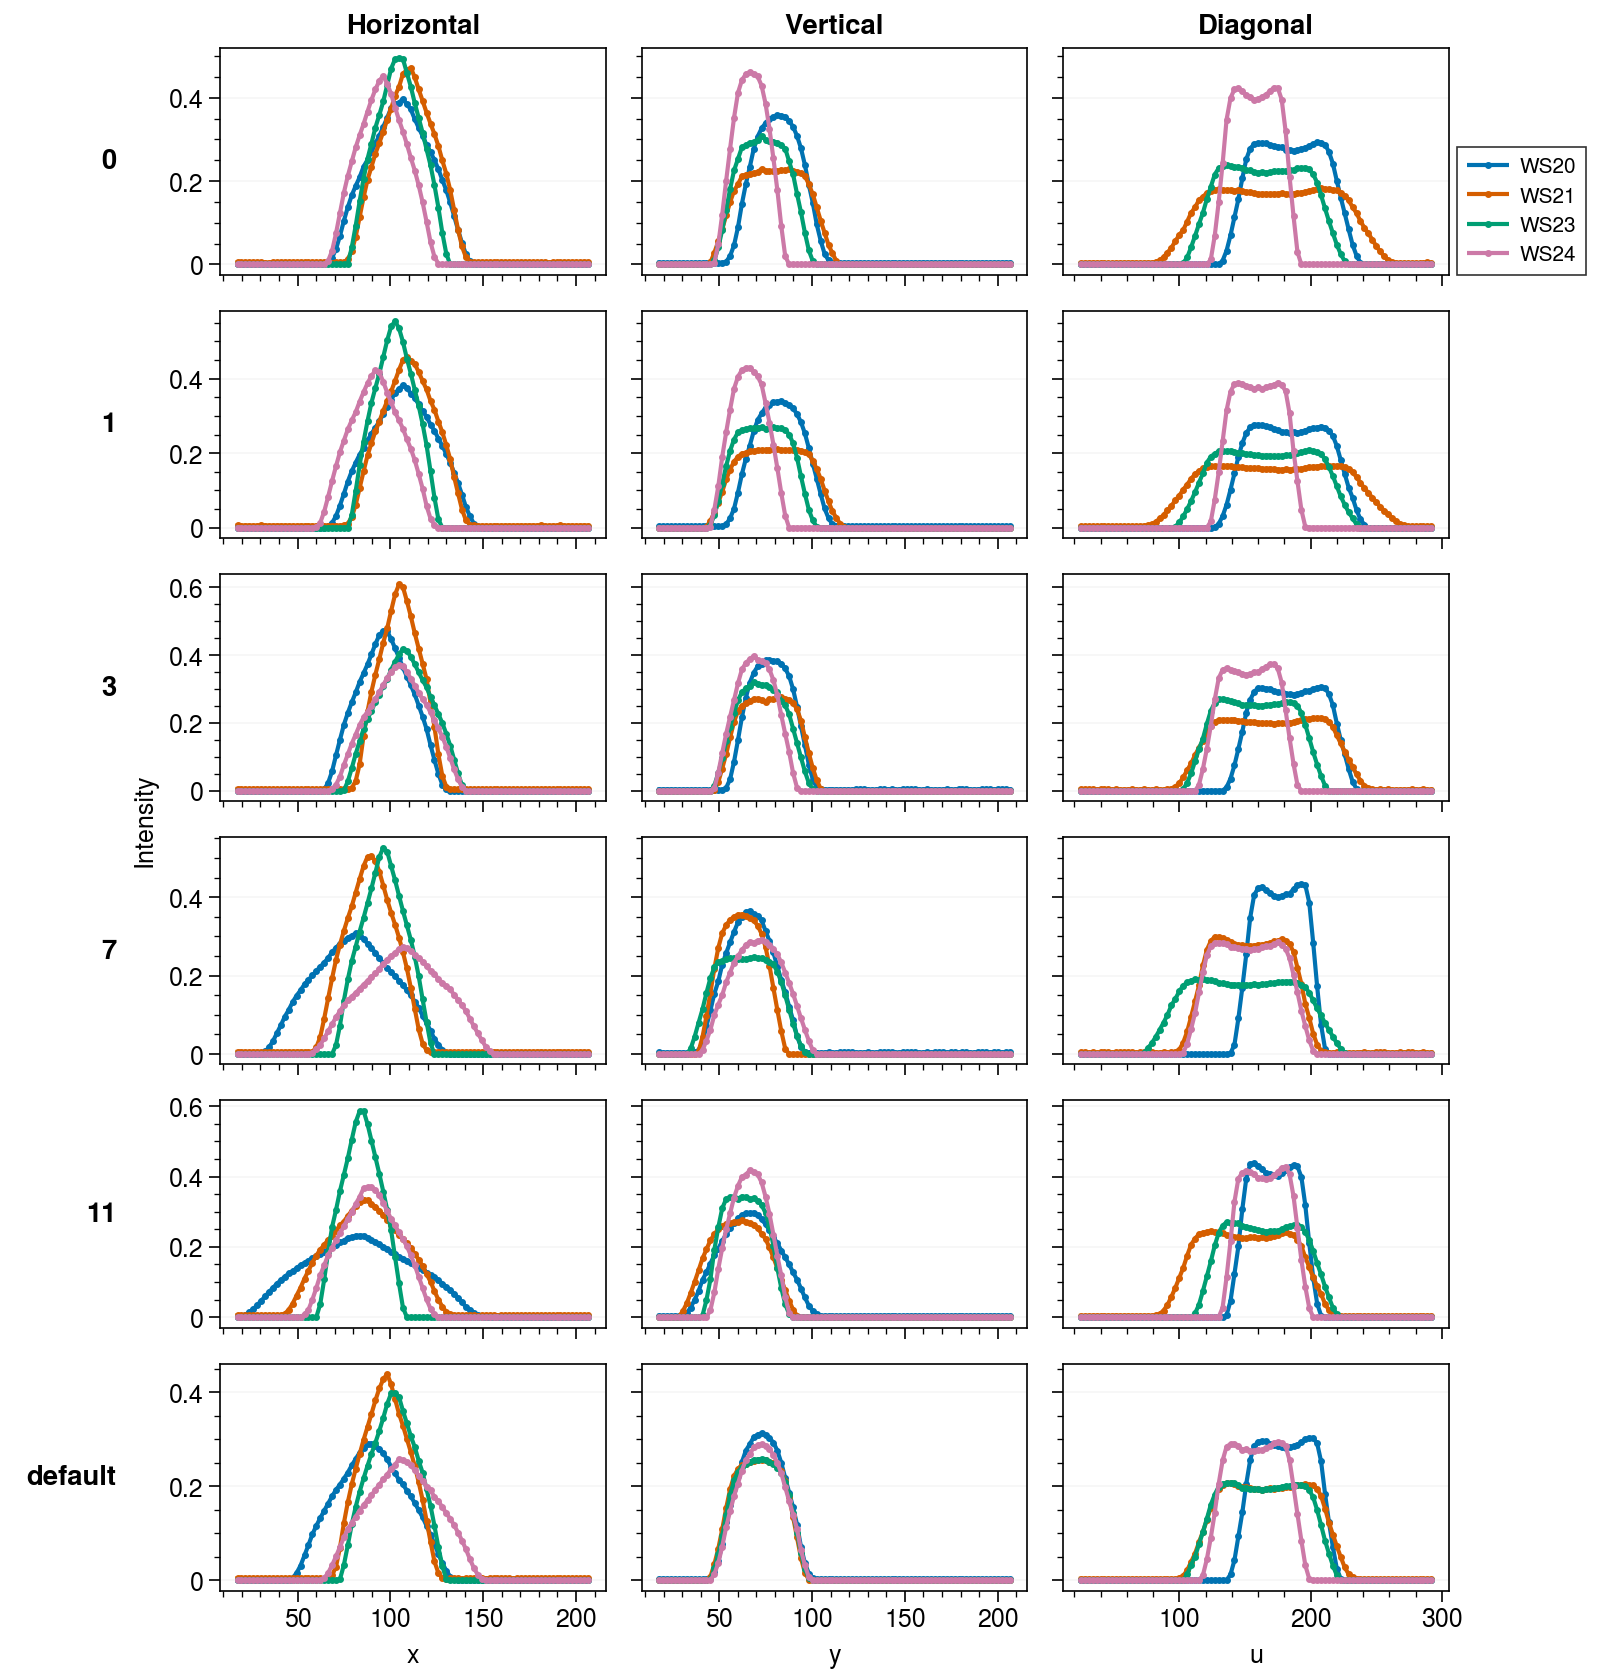

In [11]:
n_meas = len(data_list)
fig, axes = plot.subplots(nrows=n_meas, ncols=3, figsize=(8, 1.4*n_meas), spanx=False)
plt_kws = dict(legend=False, marker='.', ms=3)

for i, data in enumerate(data_list):
    for ws_id in ws_ids:
        for ax, var in zip(axes[i, :], ['x', 'y', 'u']):
            key1 = var + 'pos'
            key2 = var + 'raw'
            data[ws_id][[key1, key2]].plot(key1, ax=ax, **plt_kws)
axes.format(ylabel='Intensity', grid=False, 
            toplabels=['Horizontal', 'Vertical', 'Diagonal'],
            leftlabels=scan_indices + ['default'])
axes[0, -1].legend(labels=ws_ids, fontsize='small', loc=(1.02, 0), ncols=1)
for ax, label in zip(axes[-1, :], ['x', 'y', 'u']):
    ax.format(xlabel=label)
for ax in axes:
    ax.grid(axis='y')

It looks like the mean of the distribution is moving around, so I may have introduced steering errors when I changed the quads. 

### Estimate moments from profiles 

We're going to ignore the production settings since I didn't compute the transfer matrix for this setting. In the future we'll have a nice list from 0 to 11 (or whatever number we choose).

In [12]:
data_list = data_list[:-1]

I'm getting a negative variance for the x positions...

In [28]:
def estimate_variance(heights, positions):
    """Estimate variance from histogram."""
    N = np.sum(heights)
    x_avg = np.sum(heights * positions) / (N - 1)
    x2_avg = np.sum(heights * positions**2) / (N - 1)
    return x2_avg - x_avg**2

def estimate_moments(heights_x, heights_y, heights_u, positions, angle):
    phi = diag_wire_angle + np.radians(90.0)
    positions_u = positions
    positions_x = np.cos(phi) * positions_u
    positions_y = np.sin(phi) * positions_u
    sig_xx = estimate_variance(heights_x, positions_x)
    sig_yy = estimate_variance(heights_y, positions_y)
    sig_uu = estimate_variance(heights_u, positions_u)
    sin = np.sin(diag_wire_angle)
    cos = np.cos(diag_wire_angle)
    sig_xy = (sig_uu - sig_xx*cos**2 - sig_yy*sin**2) / (2 * sin * cos)
    return sig_xx, sig_yy, sig_xy
    
data = data_list[0]['WS20']

positions_x = data['xpos'].values
heights_x = data['xraw'].values
estimate_variance(heights_x, positions_x)

# positions = data['pos'].values
# heights_x = data['xraw'].values
# heights_y = data['yraw'].values
# heights_u = data['uraw'].values
# diag_wire_angle = -np.radians(45.0)
# sig_xx, sig_yy, sig_xy = estimate_moments(heights_x, heights_y, heights_u, positions, diag_wire_angle)

14407.48459663601


-1483.5943845415168

## Reconstruct beam moments

Collect the transfer matrices calculated from the online model in OpenXAL.

In [ ]:
transfer_mats = []
for i in scan_indices:
    matrix_elems_at_each_ws = np.loadtxt('./transfer_mat_elems_{}.dat'.format(i))
    # Each row gives the 16 elements at a different wire-scanner in the order
    # (WS02, WS20, WS21, WS23, WS24). We didn't take data from WS02, so skip the
    # first row. = 
    for matrix_elements in matrix_elems_at_each_ws[1:]:
        transfer_mats.append(matrix_elements.reshape((4, 4)))
transfer_mats = np.array(transfer_mats)
print('transfer_mats.shape =', transfer_mats.shape)